# Trénovanie modelu na základe DST indexu, F10_indexu a BZ_GSM 4h dopredu 6 dozadu
Súbor: 6_4_pridane_atr.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.9 MB/s eta 0:00:0000:0100:01


### Kontrola kapacity servera

In [1]:
!nvidia-smi

Tue Mar 14 00:36:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   31C    P8     1W / 125W |    912MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'F10_INDEX',
            'BZ_GSM',
            'DST+4']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+4'
predicators = ['DST',
            'F10_INDEX',
            'BZ_GSM']

y_col='DST+4'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

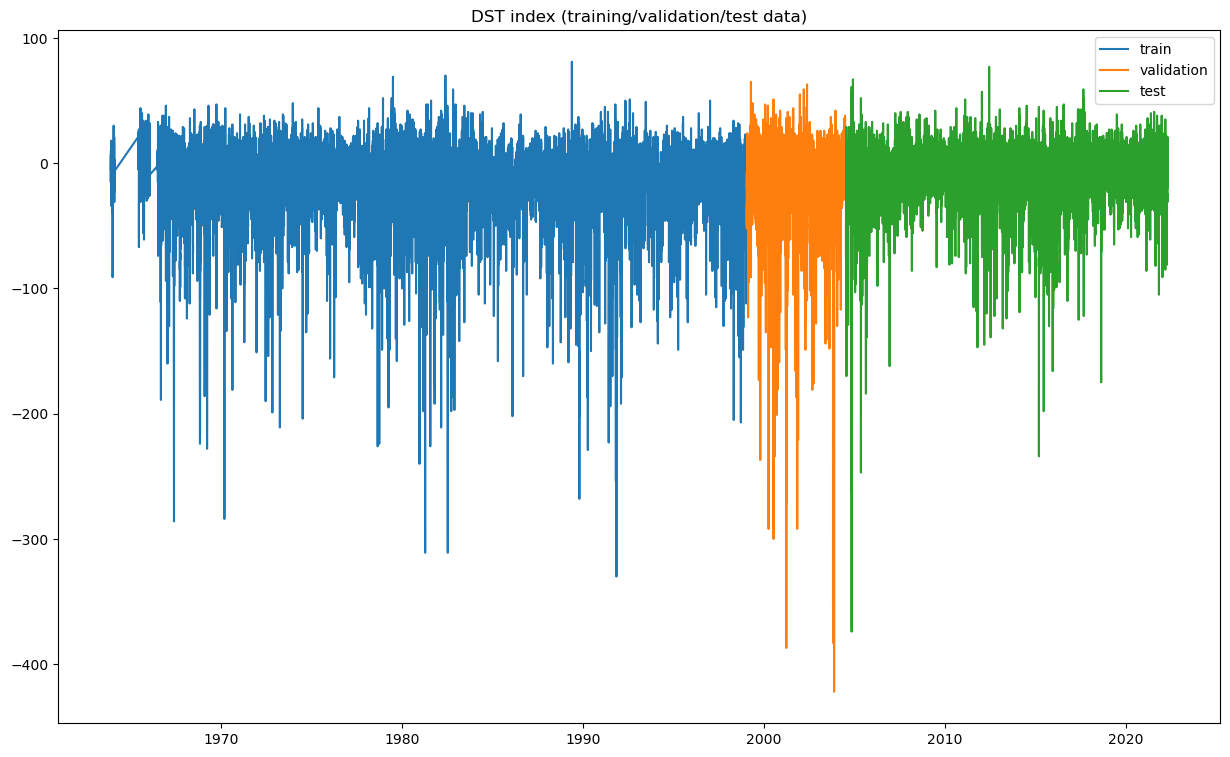

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST+2'],label='train')
plt.plot(valid['time1'],valid['DST+2'],label='validation')
plt.plot(test['time1'],test['DST+2'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  753
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [7]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional((LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))(inputs)
c = LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-14 00:36:47.228891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [8]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                           

In [88]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(3, activation='linear'))(c)
output = Flatten()(c)
output = Dense(3, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 6, 256)           135168    
 nal)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 6, 128)            197120    
                                                                 
 time_distributed_3 (TimeDis  (None, 6, 3)             387       
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 18)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 57  

In [8]:
# callbacks
saved_model = "6_4_pridane_atr.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-03-14 00:37:04.907180: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


753/753 [==============================] - ETA: 0s - loss: 130.5818 - mae: 5.1940
Epoch 1: val_mae improved from inf to 4.41355, saving model to 6_4_pridane_atr.hdf5
753/753 [==============================] - 51s 59ms/step - loss: 130.5818 - mae: 5.1940 - val_loss: 115.4003 - val_mae: 4.4136
Epoch 2/20
753/753 [==============================] - ETA: 0s - loss: 48.8325 - mae: 3.4466
Epoch 2: val_mae improved from 4.41355 to 3.20992, saving model to 6_4_pridane_atr.hdf5
753/753 [==============================] - 44s 58ms/step - loss: 48.8325 - mae: 3.4466 - val_loss: 63.6462 - val_mae: 3.2099
Epoch 3/20
753/753 [==============================] - ETA: 0s - loss: 38.4939 - mae: 3.0834
Epoch 3: val_mae did not improve from 3.20992
753/753 [==============================] - 44s 58ms/step - loss: 38.4939 - mae: 3.0834 - val_loss: 60.8026 - val_mae: 3.9645
Epoch 4/20
752/753 [============================>.] - ETA: 0s - loss: 35.6561 - mae: 2.9888
Epoch 4: val_mae improved from 3.20992 to 2.071

In [10]:
# load best model
model = keras.models.load_model('6_4_pridane_atr.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 10s 14ms/step


In [12]:
y_pred

array([[ 13.615775],
       [ 13.403035],
       [ 12.701874],
       ...,
       [-24.657076],
       [-26.89945 ],
       [-28.009188]], dtype=float32)

In [13]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124045    595]
 [  2703  27910]]


In [14]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124640
           1       0.98      0.91      0.94     30613

    accuracy                           0.98    155253
   macro avg       0.98      0.95      0.97    155253
weighted avg       0.98      0.98      0.98    155253



In [15]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [16]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,16.0,13.615775
7,2004-07-22 05:00:00,14.0,13.403035
8,2004-07-22 06:00:00,14.0,12.701874
9,2004-07-22 07:00:00,14.0,11.994748
10,2004-07-22 08:00:00,11.0,10.609622
...,...,...,...
155254,2022-04-28 20:00:00,-13.0,-15.761454
155255,2022-04-28 21:00:00,-18.0,-20.058462
155256,2022-04-28 22:00:00,-23.0,-24.657076
155257,2022-04-28 23:00:00,-26.0,-26.899450


In [17]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.816899,-9.663615
std,16.339896,15.107487
min,-374.000000,-168.637466
25%,-16.000000,-16.185303
50%,-7.000000,-7.372213
75%,0.000000,-0.223096
max,77.000000,39.453373


<AxesSubplot: >

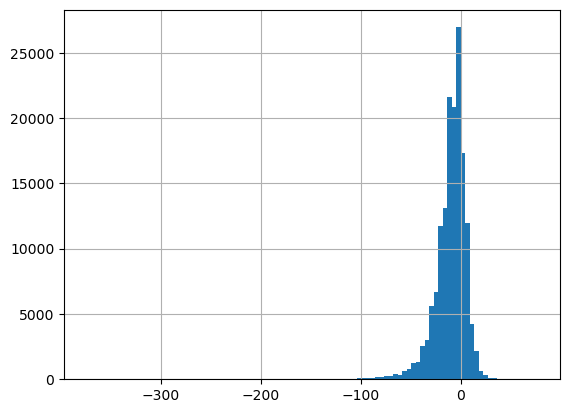

In [18]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

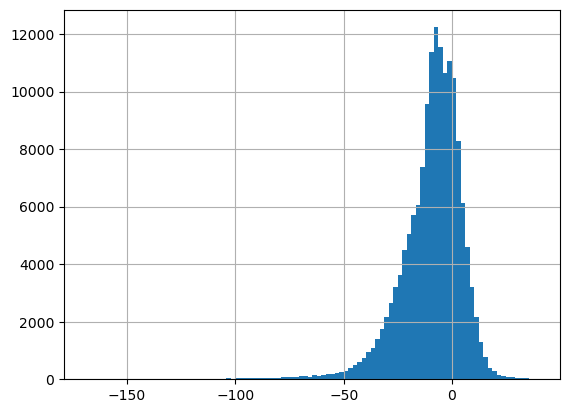

In [19]:
df["y_predict"].hist(bins=100)

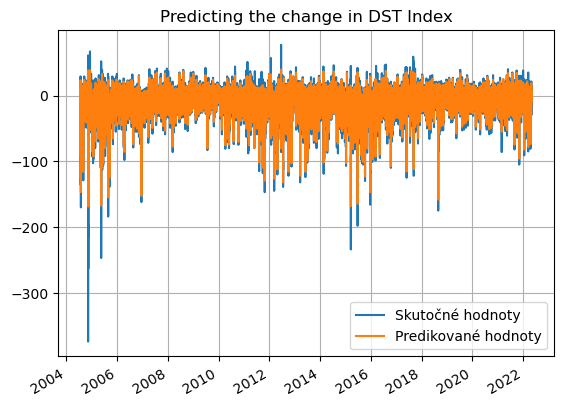

In [20]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [21]:
df.to_csv('predikcie_6_4_prid_atr.csv')

In [22]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124045    595]
 [  2703  27910]]


In [23]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)

124045
595
2703
27910


In [24]:
from sklearn.metrics import *
TN = cm[0,0] 
print("TN={}".format(TN))
FP = cm[0,1]
print("FP={}".format(FP))
FN = cm[1,0] 
print("FN={}".format(FN))
TP = cm[1,1] 
print("TP={}".format(TP))
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
fpr, tpr, threshold = roc_curve(y_test2, y_pred2)
AUC = auc(fpr, tpr)
print("AUC={}".format(AUC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

TN=124045
FP=595
FN=2703
TP=27910
TPR=0.9117041779636103
TNR=0.9952262516046213
PPV=0.9791264690405193
NPV=0.9786742197115537
FPR=0.00477374839537869
FNR=0.08829582203638976
FDR=0.02087353095948079
ACC=0.9787572542881618
AUC=0.9534652147841158
MCC=0.9320185567308547
